In [2]:
import pandas as pd
import requests

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv('Data/customer-dummy.csv')
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace(' ', '_')
df['customer_id'] = df['customer_id'].astype(int)
df

,customer_id,location,stops,apple,banana,tomato,carrot
0,1,"27.194912, 31.170663",0,30,0,30,0
1,2,"30.041785, 31.336400",0,100,0,20,0
2,3,"30.065739, 31.157911",0,50,0,0,50
3,4,"30.051256, 31.294730",1,50,100,0,0
4,5,"30.777963, 31.033020",1,0,40,0,80
5,6,"31.033550, 31.429218",1,0,150,0,0
6,7,"31.016949, 31.269983",2,100,0,0,0
7,8,"31.137431, 29.977387",2,0,0,80,0
8,9,"30.880370, 29.502285",1,0,0,40,60
9,10,"31.387000, 31.572562",1,50,60,70,50


In [4]:
data = df.copy()
data.set_index('customer_id', inplace=True)

In [5]:
data['location_lon'] = data['location'].str.extract(r'(\d+\.\d+),\s*(\d+\.\d+)', expand=True)[0]
data['location_lat'] = data['location'].str.extract(r'(\d+\.\d+),\s*(\d+\.\d+)', expand=True)[1]
data.drop('location', axis=1, inplace=True)
data

,stops,apple,banana,tomato,carrot,location_lon,location_lat
customer_id,,,,,,,
1,0,30,0,30,0,27.194912,31.170663
2,0,100,0,20,0,30.041785,31.336400
3,0,50,0,0,50,30.065739,31.157911
4,1,50,100,0,0,30.051256,31.294730
5,1,0,40,0,80,30.777963,31.033020
6,1,0,150,0,0,31.033550,31.429218
7,2,100,0,0,0,31.016949,31.269983
8,2,0,0,80,0,31.137431,29.977387
9,1,0,0,40,60,30.880370,29.502285


In [6]:
base_url = f'https://routing.openstreetmap.de/routed-car/route/v1/driving/'

In [7]:
base_lon = '27.164404'
base_lat = '31.198769'

In [8]:
def fetch_duration(lon, lat):
    response = requests.get(base_url + f"{base_lon},{base_lat};{lon},{lat}?overview=false")
    if response.status_code == 200:
        # Assuming the API returns a JSON with a 'duration' field
        json_data = response.json()
        return json_data.get('routes', None)[0].get('duration')  # Adjust according to actual API response structure
    else:
        return None

In [9]:
data_encoded = data.copy()

In [10]:
data_encoded['duration'] = data_encoded.apply(lambda row: fetch_duration(row['location_lon'], row['location_lat']), axis=1)


In [11]:
data_encoded['stops_s'] = data_encoded['stops'] * 12 * 60 * 60
data_encoded['duration_plus'] = data_encoded['duration'] + data_encoded['stops_s']

In [12]:
data_encoded

,stops,apple,banana,tomato,carrot,location_lon,location_lat,duration,stops_s,duration_plus
customer_id,,,,,,,,,,
1,0,30,0,30,0,27.194912,31.170663,2412.0,0,2412.0
2,0,100,0,20,0,30.041785,31.336400,15126.4,0,15126.4
3,0,50,0,0,50,30.065739,31.157911,14320.0,0,14320.0
4,1,50,100,0,0,30.051256,31.294730,15016.5,43200,58216.5
5,1,0,40,0,80,30.777963,31.033020,19251.2,43200,62451.2
6,1,0,150,0,0,31.033550,31.429218,20851.1,43200,64051.1
7,2,100,0,0,0,31.016949,31.269983,21132.2,86400,107532.2
8,2,0,0,80,0,31.137431,29.977387,19424.9,86400,105824.9
9,1,0,0,40,60,30.880370,29.502285,20856.1,43200,64056.1


In [13]:
X = data_encoded[['duration_plus']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [14]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
data_encoded['cluster'] = kmeans.fit_predict(X_scaled)

c:\Users\youss\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\youss\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [15]:
data_encoded

,stops,apple,banana,tomato,carrot,location_lon,location_lat,duration,stops_s,duration_plus,cluster
customer_id,,,,,,,,,,,
1,0,30,0,30,0,27.194912,31.170663,2412.0,0,2412.0,2
2,0,100,0,20,0,30.041785,31.336400,15126.4,0,15126.4,2
3,0,50,0,0,50,30.065739,31.157911,14320.0,0,14320.0,2
4,1,50,100,0,0,30.051256,31.294730,15016.5,43200,58216.5,1
5,1,0,40,0,80,30.777963,31.033020,19251.2,43200,62451.2,1
6,1,0,150,0,0,31.033550,31.429218,20851.1,43200,64051.1,1
7,2,100,0,0,0,31.016949,31.269983,21132.2,86400,107532.2,0
8,2,0,0,80,0,31.137431,29.977387,19424.9,86400,105824.9,0
9,1,0,0,40,60,30.880370,29.502285,20856.1,43200,64056.1,1


<ipython-input-16-a4656e5a5d70>:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(data_encoded['cluster'], data_encoded['duration_plus'], cmap='viridis')
c:\Users\youss\anaconda3\lib\site-packages\matplotlib\collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


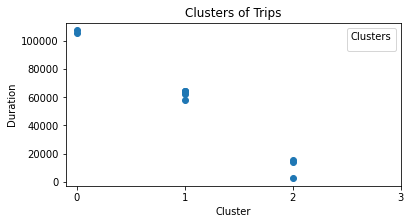

In [16]:
plt.figure(figsize=(6, 3))
scatter = plt.scatter(data_encoded['cluster'], data_encoded['duration_plus'], cmap='viridis')
plt.legend(*scatter.legend_elements(), title="Clusters")
# make x labels [1,2,3 ] only
plt.xticks([0,1, 2, 3])
plt.ylabel('Duration')
plt.xlabel('Cluster')
plt.title('Clusters of Trips')
plt.show()


In [17]:
df_order = data_encoded.groupby('cluster')['duration_plus'].mean()
df_order = df_order.sort_values(ascending=True)

df_order


cluster
2     10619.466667
1     62651.940000
0    106678.550000
Name: duration_plus, dtype: float64

In [18]:
batchs = dict()
batchs['apple'] = ['1-5', '5-10', '10-14']
batchs['banana'] = ['1-5', '5-10', '10-14']
batchs['tomato'] = ['1-5', '5-10', '10-14']
batchs['carrot'] = ['1-2', '3-4', '5-6']


In [19]:
def getIndexFromClusterAsc(cluster):
    df_order = data_encoded.groupby('cluster')['duration_plus'].mean()
    df_order = df_order.sort_values(ascending=True) 

    return df_order.index[cluster]

In [20]:
data_encoded.head()

,stops,apple,banana,tomato,carrot,location_lon,location_lat,duration,stops_s,duration_plus,cluster
customer_id,,,,,,,,,,,
1,0,30,0,30,0,27.194912,31.170663,2412.0,0,2412.0,2
2,0,100,0,20,0,30.041785,31.336400,15126.4,0,15126.4,2
3,0,50,0,0,50,30.065739,31.157911,14320.0,0,14320.0,2
4,1,50,100,0,0,30.051256,31.294730,15016.5,43200,58216.5,1
5,1,0,40,0,80,30.777963,31.033020,19251.2,43200,62451.2,1


In [21]:
return_df = None

In [22]:
return_df = pd.DataFrame()

In [23]:
return_df = pd.DataFrame(columns=['customer_id', 'apples_amount', 'bananas_amount', 'carrots_amount', 'tomatoes_amount', 'apple_batch', 'banana_batch', 'carrot_batch', 'tomato_batch', 'duration_plus', 'cluster'])

for index, row in data_encoded.iterrows():
    customer_id = index
    apple_amount = row['apple']
    banana_amount = row['banana']
    carrot_amount = row['carrot']
    tomato_amount = row['tomato']
    duration_plus = row['duration_plus']
    cluster = row['cluster']
    apple_batch = 0 if row['apple'] == 0 else batchs['apple'][getIndexFromClusterAsc(cluster)]
    banana_batch = 0 if row['banana'] == 0 else batchs['banana'][getIndexFromClusterAsc(cluster)]
    carrot_batch = 0 if row['carrot'] == 0 else batchs['carrot'][getIndexFromClusterAsc(cluster)]
    tomato_batch = 0 if row['tomato'] == 0 else batchs['tomato'][getIndexFromClusterAsc(cluster)]
    return_df = return_df.append({'customer_id': customer_id, 'apple_amount': apple_amount, 'banana_amount': banana_amount, 'carrot_amount': carrot_amount, 'tomato_amount': tomato_amount, 'apple_batch': apple_batch, 'banana_batch': banana_batch, 'carrot_batch': carrot_batch, 'tomato_batch': tomato_batch, 'duration_plus': duration_plus, 'cluster': cluster}, ignore_index=True)

return_df.drop(['apples_amount',	'bananas_amount','carrots_amount',	'tomatoes_amount'], axis=1, inplace=True)

<ipython-input-23-101eedbebe2b>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return_df = return_df.append({'customer_id': customer_id, 'apple_amount': apple_amount, 'banana_amount': banana_amount, 'carrot_amount': carrot_amount, 'tomato_amount': tomato_amount, 'apple_batch': apple_batch, 'banana_batch': banana_batch, 'carrot_batch': carrot_batch, 'tomato_batch': tomato_batch, 'duration_plus': duration_plus, 'cluster': cluster}, ignore_index=True)
<ipython-input-23-101eedbebe2b>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return_df = return_df.append({'customer_id': customer_id, 'apple_amount': apple_amount, 'banana_amount': banana_amount, 'carrot_amount': carrot_amount, 'tomato_amount': tomato_amount, 'apple_batch': apple_batch, 'banana_batch': banana_batch, 'carrot_batch': carrot_batch, 'tomato_batc

In [24]:
return_df

,customer_id,apple_batch,banana_batch,carrot_batch,tomato_batch,duration_plus,cluster,apple_amount,banana_amount,carrot_amount,tomato_amount
0,1,1-5,0,0,1-5,2412.0,2,30.0,0.0,0.0,30.0
1,2,1-5,0,0,1-5,15126.4,2,100.0,0.0,0.0,20.0
2,3,1-5,0,1-2,0,14320.0,2,50.0,0.0,50.0,0.0
3,4,5-10,5-10,0,0,58216.5,1,50.0,100.0,0.0,0.0
4,5,0,5-10,3-4,0,62451.2,1,0.0,40.0,80.0,0.0
5,6,0,5-10,0,0,64051.1,1,0.0,150.0,0.0,0.0
6,7,10-14,0,0,0,107532.2,0,100.0,0.0,0.0,0.0
7,8,0,0,0,10-14,105824.9,0,0.0,0.0,0.0,80.0
8,9,0,0,3-4,5-10,64056.1,1,0.0,0.0,60.0,40.0
9,10,5-10,5-10,3-4,5-10,64484.8,1,50.0,60.0,50.0,70.0
